# General Tensor Network SVD Analysis and RMT Comparisons

This notebook provides a general function to analyze the singular value distribution of a matrix resulting from the contraction and matricization of an arbitrary Tensor Network defined using `tensorkrowch`.

We will define:
1.  A core function `analyze_tn_svd` that takes a network definition, performs the contraction and SVD, and returns the singular values and effective dimension.
2.  Theoretical probability density functions (PDFs) for relevant Random Matrix Theory (RMT) distributions (Quarter Circle, Fuss-Catalan P2).
3.  A plotting function `plot_svd_histogram_vs_theory` that takes the SVD results and plots them against the chosen theoretical distribution after appropriate scaling.

Finally, we will demonstrate the usage with two examples:
*   **Quarter Circle Law:** Analyzing a single large random matrix.
*   **Fuss-Catalan P2:** Analyzing the product of two large random matrices.

In [41]:
# Cell 2: Code (Imports and Setup) - Modified

# === Imports ===
import torch
import matplotlib.pyplot as plt
import tensorkrowch as tk
import numpy as np
from functools import reduce
import warnings
import traceback # Keep for error printing

# Ignore potential numerical warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Matplotlib Font Configuration ---
# Try setting a font known to have better glyph coverage like DejaVu Sans
# and configure math text rendering properly.
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'cm' # Use Computer Modern for math text (good for symbols)
plt.rcParams['svg.fonttype'] = 'none' # Ensures text remains text in SVG outputs if needed
# --- End Font Configuration ---

# Configure Matplotlib for potentially higher resolution in notebooks
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-darkgrid') # Optional: Use a nice style

## 1. General Tensor Network SVD Analysis Function

This function is the core engine. It takes the definition of a tensor network and how to matricize the result, performs the necessary operations using `tensorkrowch` and `torch`, and returns the raw singular values and the effective dimension `N` needed for scaling in RMT comparisons. It does *not* perform any scaling or plotting itself.

In [43]:
def analyze_tn_svd(
    nodes_def, edges_def, input_labels, output_labels, dtype=torch.float64
):
    """
    Builds, contracts, and matricizes a TensorKrowch network, calculates SVD.
    Refactored for conciseness.

    Args:
        nodes_def (list): List of dicts defining nodes for tk.TensorNetwork.
        edges_def (list): List of tuples defining edges for tk.TensorNetwork.
        input_labels (list): List of axis names for the rows of the final matrix.
        output_labels (list): List of axis names for the columns of the final matrix.
        dtype (torch.dtype): Data type for torch tensors (float64 recommended).

    Returns:
        tuple: (svdvals, N) where svdvals is a numpy array of singular values,
               and N is the min(input_dim, output_dim) for scaling, or None if error.
               Returns (None, None) on error.
    """
    print("--- Starting Tensor Network Analysis ---")
    try:
        # --- 1. Build and Contract Network ---
        print("Building and Contracting Network...")
        net = tk.TensorNetwork()
        nodes = {n['name']: tk.Node(network=net, init_method='randn', dtype=dtype, **n)
                 for n in nodes_def}
        for n1, a1, n2, a2 in edges_def:
            nodes[n1][a1] ^ nodes[n2][a2]

        leaves = list(nodes.values())
        if not leaves: raise ValueError("No nodes defined in the network.")
        result_node = leaves[0] if len(leaves) == 1 else reduce(lambda a, b: a @ b, leaves)

        # --- 2. Matricize Result ---
        print("Matricizing Result...")
        ordered_labels = input_labels + output_labels
        current_axis_names = result_node.axes_names
        missing_labels = [lbl for lbl in ordered_labels if lbl not in current_axis_names]
        if missing_labels:
            raise ValueError(f"Labels {missing_labels} not found in axes {current_axis_names}")

        # Permute if necessary
        if list(ordered_labels) != list(current_axis_names):
            permute_indices = tuple(current_axis_names.index(label) for label in ordered_labels)
            permuted_node = result_node.permute(permute_indices)
        else:
            permuted_node = result_node # No permutation needed

        # Reshape to matrix
        permuted_shape = permuted_node.shape
        input_dim = int(np.prod(permuted_shape[:len(input_labels)]) if input_labels else 1)
        output_dim = int(np.prod(permuted_shape[len(input_labels):]) if output_labels else 1)
        input_dim, output_dim = max(1, input_dim), max(1, output_dim)
        matrix_torch = permuted_node.tensor.reshape(input_dim, output_dim)

        if matrix_torch.numel() == 0: raise ValueError("Resulting matrix is empty.")
        print(f"Result matrix dimensions: {input_dim} x {output_dim}")

        # --- 3. Calculate SVD ---
        print("Calculating SVD...")
        svdvals = torch.linalg.svdvals(matrix_torch).cpu().numpy()
        if len(svdvals) == 0: raise ValueError("Singular values calculation resulted in empty array.")

        N = min(input_dim, output_dim) # Effective dimension for RMT scaling
        print(f"SVD successful. Effective dimension N = {N}")
        print("--- Analysis Function Finished ---")
        return svdvals, N

    except Exception as e:
        print(f"Error during Tensor Network analysis: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        return None, None

## 2. Theoretical RMT Distribution Functions

Here we define the PDFs for the distributions we want to compare against.

In [45]:
# === Theoretical Distribution Functions ===

def quarter_circle_law(x, sigma2=1.):
    """Quarter Circle law density: (1 / (pi * sigma2)) * sqrt(4*sigma2 - x^2)"""
    R_sq = 4. * sigma2
    R = 2. * np.sqrt(sigma2)
    density = np.zeros_like(x)
    mask = (x > 1e-9) & (x < R)
    density[mask] = (1. / (np.pi * sigma2)) * np.sqrt(R_sq - x[mask]**2)
    return np.nan_to_num(density)

def fuss_catalan_p2(x):
    """Fuss-Catalan P_2(x) distribution density."""
    density = np.zeros_like(x, dtype=float)
    mask = (x > 1e-12) & (x < 27./4.)
    xm = x[mask]
    sqrt_term = np.sqrt(np.maximum(0., 81. - 12. * xm))
    term_brackets = np.maximum(0., 27. + 3. * sqrt_term)
    term_pow_1_3 = np.power(term_brackets, 1./3.)
    term_pow_2_3 = np.power(term_brackets, 2./3.)
    x_pow_1_3 = np.power(xm, 1./3.)
    x_pow_2_3 = np.power(xm, 2./3.)
    const = (np.sqrt(3.) * np.power(2., 1./3.)) / (12. * np.pi)
    num = (np.power(2., 1./3.) * term_pow_2_3 - 6. * x_pow_1_3)
    den = x_pow_2_3 * term_pow_1_3
    valid_den = np.abs(den) > 1e-15
    density_masked = np.zeros_like(xm)
    density_masked[valid_den] = const * num[valid_den] / den[valid_den]
    density[mask] = density_masked
    return np.maximum(0, np.nan_to_num(density))


# Dictionary mapping dist_type names to functions and properties
THEORY_DISTRIBUTIONS = {
    'quarter_circle': {
        'function': quarter_circle_law,
        'scaling_type': 's/sqrt(N)',
        'theory_range': (0, 2.0), # Assumes sigma2=1
        'label': 'Quarter Circle Law: √(4-x²)/π',
        'xlabel': 's / √N',
        'title': 'Quarter Circle Law (s/√N)'
    },
    'fuss_catalan_p2': {
        'function': fuss_catalan_p2,
        'scaling_type': 's^2/N^2',
        'theory_range': (0, 27./4.),
        # --- Modified Labels ---
        'label': 'Theory: Fuss-Catalan P2(x)', # Changed P₂(x)
        'xlabel': 'x = s^2 / N^2',           # Changed s²/N² (using ^)
        'title': 'Fuss-Catalan P2(x) Distribution'  # Changed P₂(x)
        # --- End Modifications ---
    }
    # Add Marchenko-Pastur etc. here if needed
}

## 3. Plotting Function

This function takes the singular values `svdvals` and dimension `N` (output from `analyze_tn_svd`), along with the desired `dist_type`, performs the appropriate scaling, and plots the histogram against the corresponding theoretical curve.

In [47]:
# Cell 8: Code (Plotting Function - MODIFIED)

def plot_svd_histogram_vs_theory(svdvals, N, dist_type, num_bins=75, sigma2=1.0):
    """
    Scales SVD values according to dist_type and plots histogram vs theory.
    Includes robust ylim handling for potentially divergent theories near x=0.

    Args:
        svdvals (np.ndarray): Array of singular values from analyze_tn_svd.
        N (int): Effective dimension N from analyze_tn_svd.
        dist_type (str): Key for THEORY_DISTRIBUTIONS ('quarter_circle', 'fuss_catalan_p2', etc.).
        num_bins (int): Number of histogram bins.
        sigma2 (float): Variance of matrix entries (usually 1 for randn).
    """
    if svdvals is None or N is None or N == 0:
        print("Invalid input (svdvals or N missing/zero). Cannot plot.")
        return
    if dist_type not in THEORY_DISTRIBUTIONS:
        print(f"Error: Unknown distribution type '{dist_type}'.")
        return

    print(f"--- Plotting for {dist_type} ---")
    config = THEORY_DISTRIBUTIONS[dist_type]
    theory_func = config['function']
    scaling_type = config['scaling_type']
    theory_range = config['theory_range']
    if dist_type == 'quarter_circle': theory_range = (0, 2.0 * np.sqrt(sigma2))

    # --- Perform Scaling ---
    # (Scaling logic remains the same)
    if scaling_type == 's/sqrt(N)':
        scaled_values = svdvals / np.sqrt(N)
        data_label = f'Empirical Data (s/√N), N={N}'
    elif scaling_type == 's^2/N^2':
        scaled_values = (svdvals**2) / (N**2)
        data_label = f'Empirical Data (s²/N²), N={N}'
    elif scaling_type == 's^2/N': # Example if adding Marchenko-Pastur
         scaled_values = (svdvals**2) / N
         data_label = f'Empirical Data (s²/N), N={N}'
    else:
        print(f"Error: Unknown scaling type '{scaling_type}'")
        return

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    hist_range = (0, theory_range[1] * 1.05)

    # 1. Histogram
    counts, bin_edges, _ = plt.hist(
        scaled_values, bins=num_bins, density=True, alpha=0.7,
        color='steelblue', edgecolor='black', label=data_label, range=hist_range
    )

    # 2. Theory Curve
    x_theory = np.linspace(1e-6, hist_range[1], 500)
    theory_args = {'sigma2': sigma2} if dist_type == 'quarter_circle' else {}
    y_theory = theory_func(x_theory, **theory_args)
    plt.plot(x_theory, y_theory, 'r-', lw=1.5, label=config['label'])

    # 3. Customize Plot
    plt.title(config['title'])
    plt.xlabel(config['xlabel'])
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(hist_range[0] - 0.05, hist_range[1])

    # --- MODIFIED YLIM Calculation ---
    # Calculate max density away from potential divergence at x=0 more robustly
    # Use a larger offset (e.g., x > 0.1 or 0.05)
    safe_theory_mask = (x_theory > 0.05) & (x_theory < theory_range[1] * 0.99)
    if np.any(safe_theory_mask):
        # Ensure we only take max from finite values in the safe range
        finite_safe_y = y_theory[safe_theory_mask][np.isfinite(y_theory[safe_theory_mask])]
        max_theory_dens_safe = np.max(finite_safe_y) if len(finite_safe_y) > 0 else 0
    else:
         max_theory_dens_safe = 0

    max_hist_dens = np.max(counts) if len(counts) > 0 else 1.0

    # Set ylim based on histogram and the SAFE maximum of the theory curve
    final_ylim_upper = max(max_hist_dens, max_theory_dens_safe) * 1.20 # Add 20% margin
    plt.ylim(0, final_ylim_upper)
    # --- End MODIFIED YLIM Calculation ---

    plt.tight_layout()
    plt.show()

## 4. Example 1: Quarter Circle Law

We define a network consisting of a single $N \times N$ random matrix. The SVD analysis should yield the Quarter Circle Law for the $s/\sqrt{N}$ scaling.

--- Starting Tensor Network Analysis ---
Building and Contracting Network...
Matricizing Result...
Result matrix dimensions: 1000 x 1000
Calculating SVD...
SVD successful. Effective dimension N = 1000
--- Analysis Function Finished ---
--- Plotting for quarter_circle ---


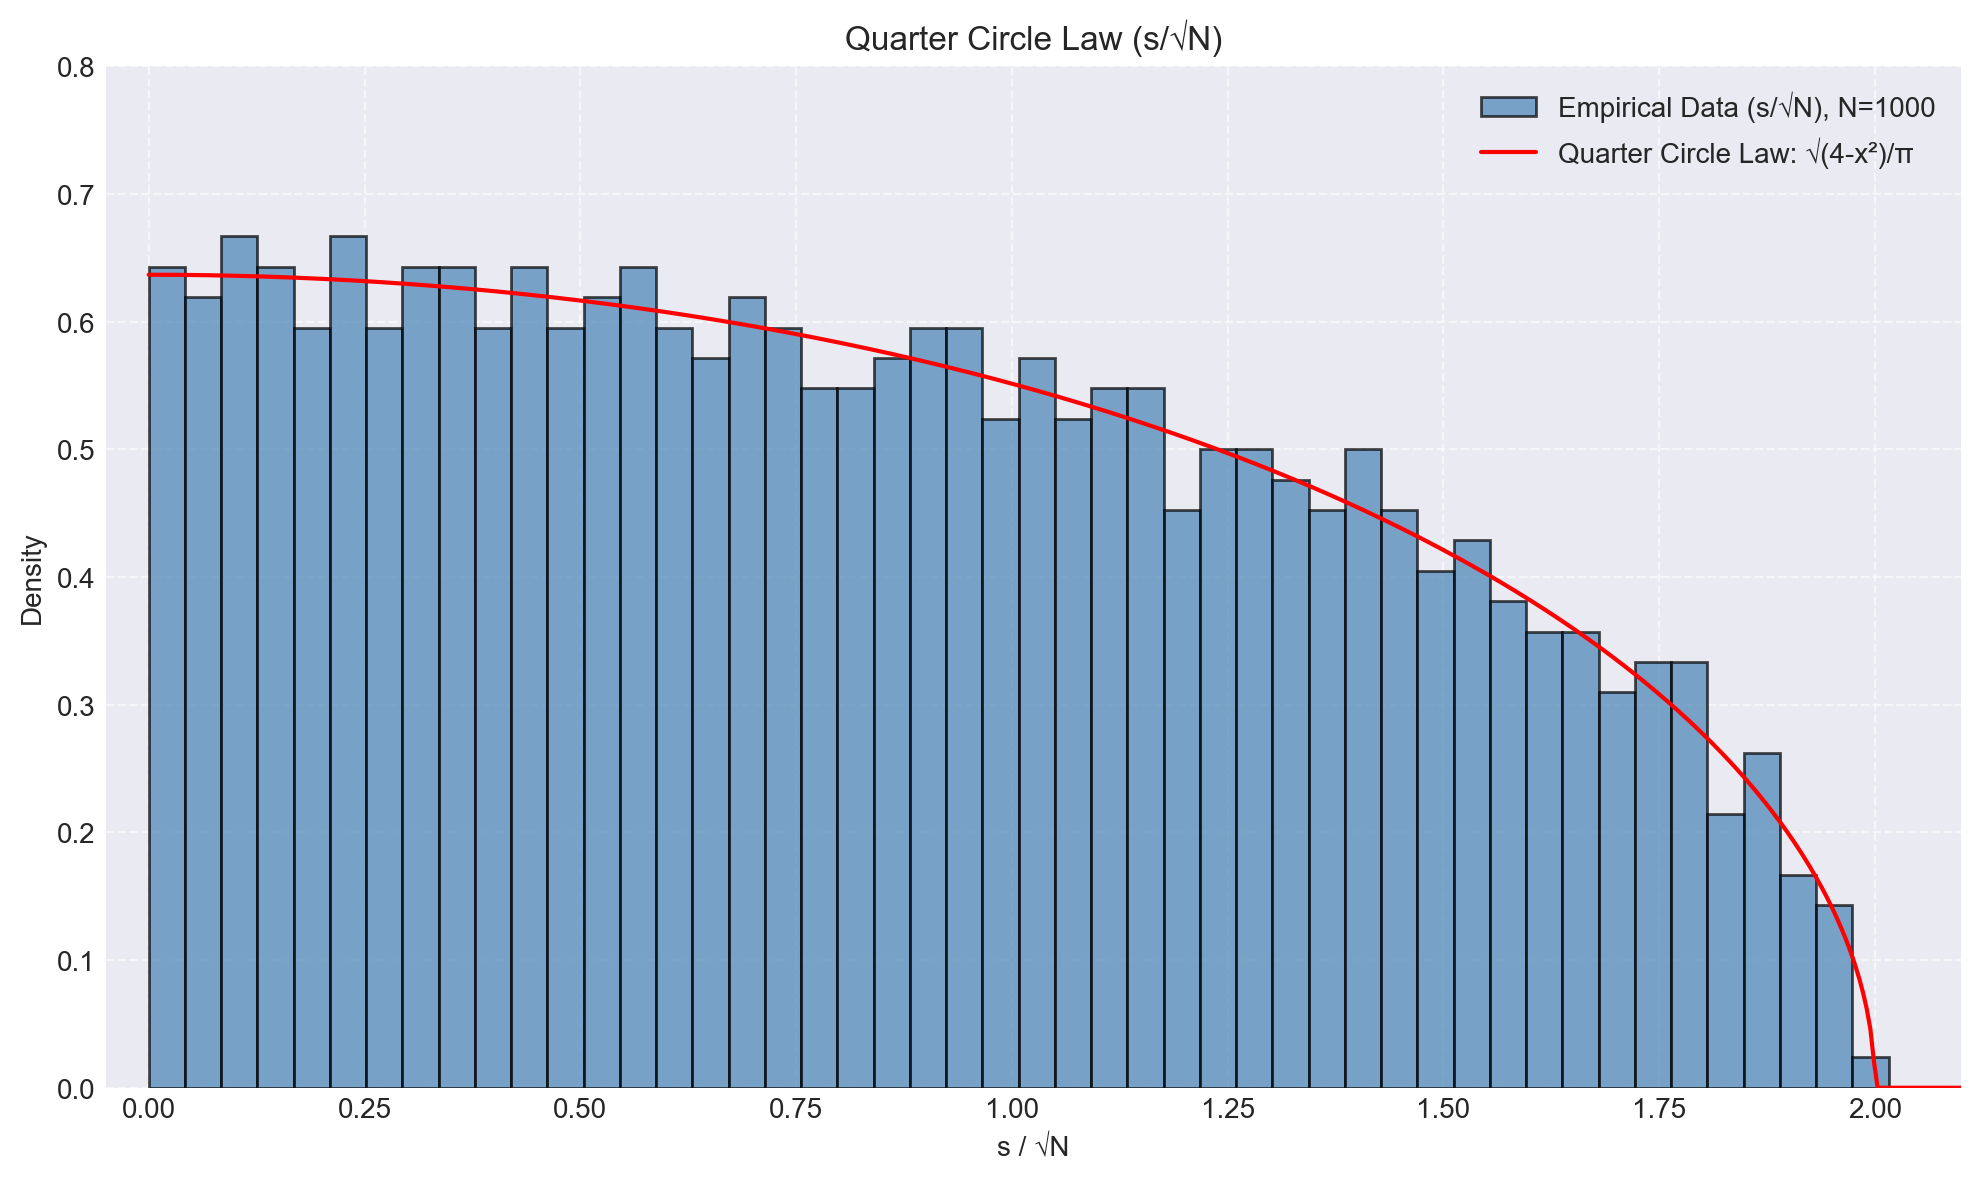

In [49]:
# === Example 1: Quarter Circle ===
N_qc = 1000 # Matrix dimension

# Define the tensor network: just a single N x N matrix (Node 'A')
nodes_qc = [{'name': 'A', 'shape': (N_qc, N_qc), 'axes_names': ('a1', 'a2')}]
edges_qc = []
input_labels_qc = ['a1'] # Rows
output_labels_qc = ['a2'] # Columns

# Run the general analysis function
svdvals_qc, N_eff_qc = analyze_tn_svd(
    nodes_qc, edges_qc, input_labels_qc, output_labels_qc, dtype=torch.float64
)

# Plot the results against the Quarter Circle theory
plot_svd_histogram_vs_theory(svdvals_qc, N_eff_qc, 'quarter_circle', num_bins=50)

## 5. Example 2: Fuss-Catalan P2 Distribution

Here, we define a network representing the product of two $N \times N$ random matrices, $C = A B$. The theory predicts that the distribution of $s^2/N^2$ (where $s$ are singular values of $C$) follows the Fuss-Catalan P2 distribution.

--- Starting Tensor Network Analysis ---
Building and Contracting Network...
Matricizing Result...
Result matrix dimensions: 1000 x 1000
Calculating SVD...
SVD successful. Effective dimension N = 1000
--- Analysis Function Finished ---
--- Plotting for fuss_catalan_p2 ---


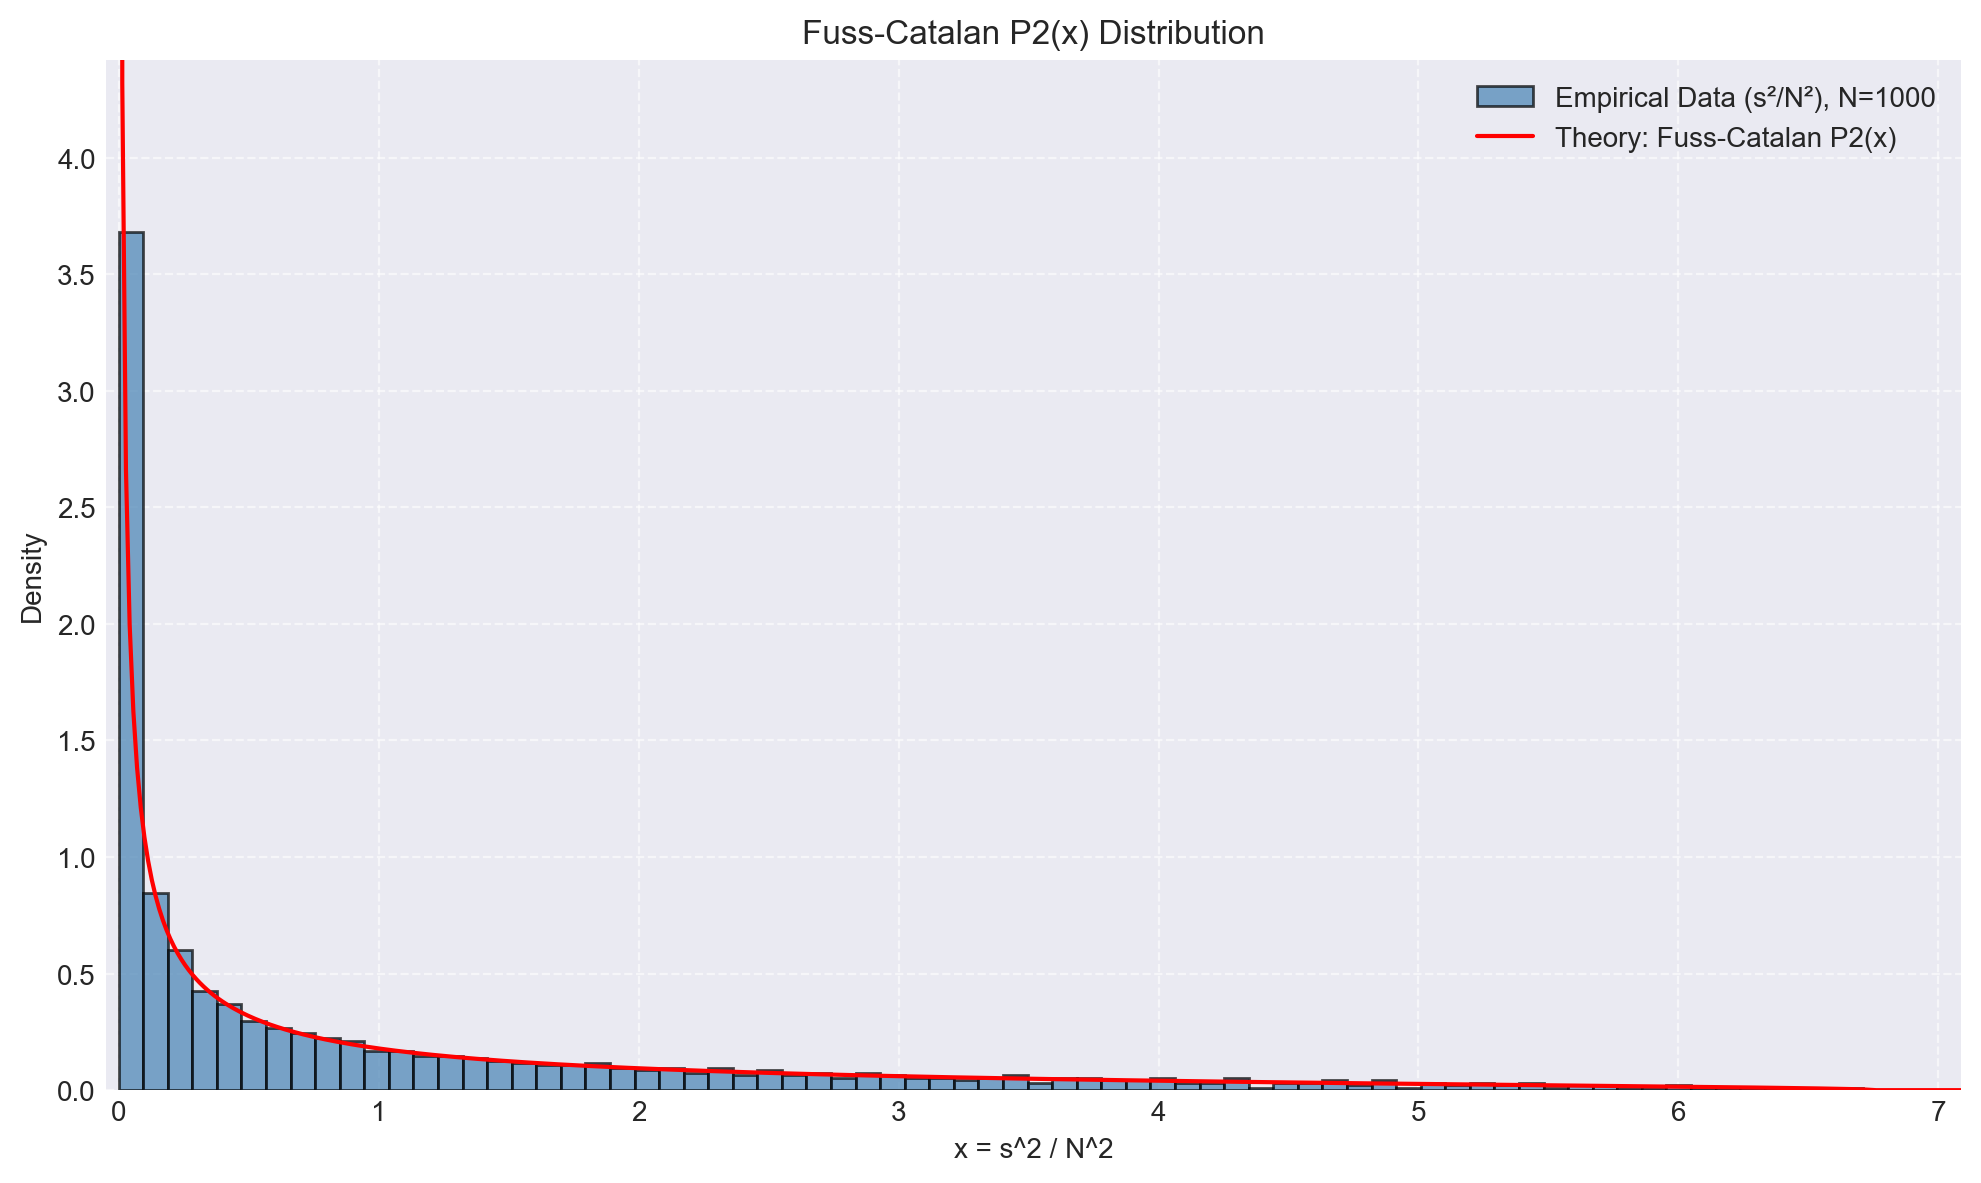

In [51]:
# === Example 2: Fuss-Catalan P2 ===
N_fc2 = 1000 # Matrix dimension

# Define the tensor network: A and B nodes, connected for matrix product
nodes_fc2 = [
    {'name': 'A', 'shape': (N_fc2, N_fc2), 'axes_names': ('a1', 'a2')},
    {'name': 'B', 'shape': (N_fc2, N_fc2), 'axes_names': ('b1', 'b2')}
]
edges_fc2 = [('A', 'a2', 'B', 'b1')] # Contract inner dimensions a2 -- b1
input_labels_fc2 = ['a1'] # Row index from A
output_labels_fc2 = ['b2'] # Column index from B

# Run the general analysis function
svdvals_fc2, N_eff_fc2 = analyze_tn_svd(
    nodes_fc2, edges_fc2, input_labels_fc2, output_labels_fc2, dtype=torch.float64
)

# Plot the results against the Fuss-Catalan P2 theory
plot_svd_histogram_vs_theory(svdvals_fc2, N_eff_fc2, 'fuss_catalan_p2', num_bins=75)

## 6. Observations

The plots generated above demonstrate the agreement between the singular value spectra obtained from Tensor Network computations (even simple ones like a single matrix or a product) and the predictions of Random Matrix Theory. The `analyze_tn_svd` function can be readily applied to more complex networks, and the `plot_svd_histogram_vs_theory` function can be extended by adding more distributions to the `THEORY_DISTRIBUTIONS` dictionary.

## 7. N-Network


Input the dimension of the Hilbert space associated with each edge

In [61]:
D = 50

Now plot the histogram ofthe singular values for the "N" network

(array([1.4624215 , 0.49760316, 0.34059854, 0.25196704, 0.1924572 ,
        0.15193984, 0.11395492, 0.08103461, 0.05064663, 0.02279098]),
 array([8.29441660e-07, 3.15915227e-01, 6.31829619e-01, 9.47744071e-01,
        1.26365840e+00, 1.57957280e+00, 1.89548731e+00, 2.21140170e+00,
        2.52731609e+00, 2.84323049e+00, 3.15914488e+00]),
 <BarContainer object of 10 artists>)

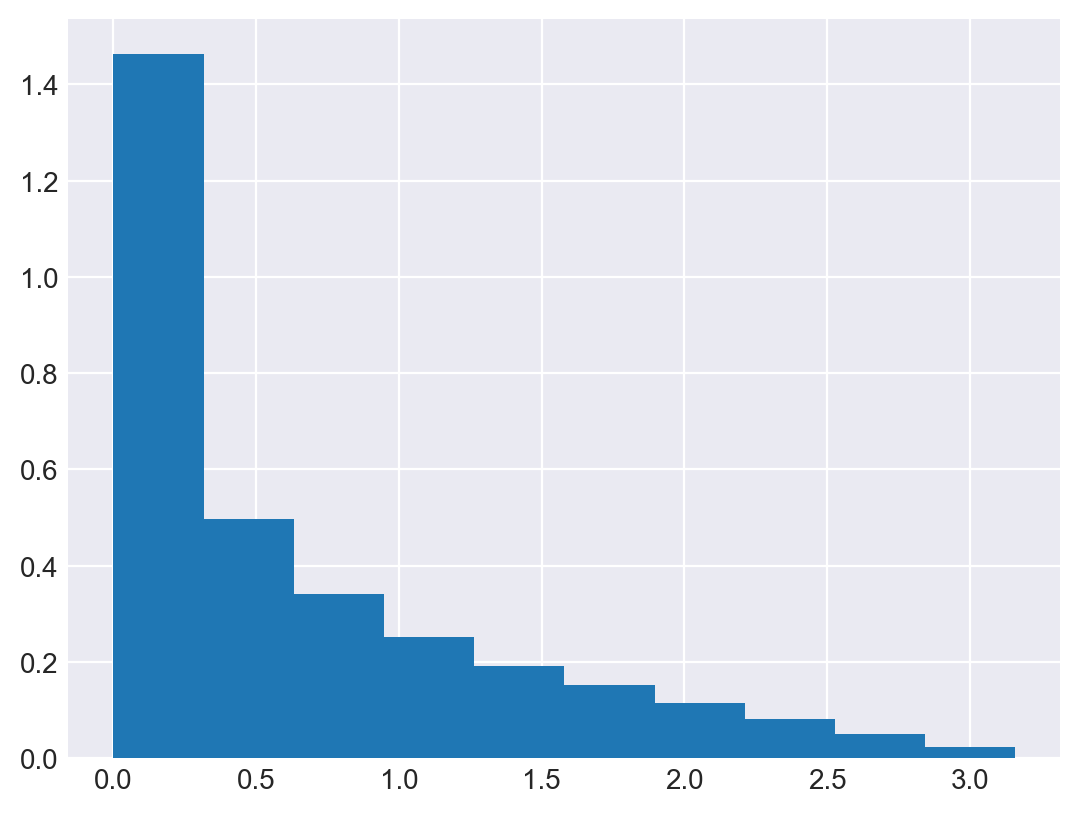

In [67]:
net1 = tk.TensorNetwork()
node1 = tk.randn(shape=(D, D, D), axes_names=('L1', 'cross', 'E1'), name='node1', network=net1)
node2 = tk.randn(shape=(D, D), axes_names=('E1', 'R1'), name='node2', network=net1)
node3 = tk.randn(shape=(D, D), axes_names=('L2', 'E2'), name='node3', network=net1)
node4 = tk.randn(shape=(D, D, D), axes_names=('E2', 'cross', 'R2'), name='node4', network=net1)
node1['E1'] ^ node2['E1']
node1['cross'] ^ node4['cross']
node3['E2'] ^ node4['E2']
result = node1 @ node2 @ node4 @ node3
result = tk.permute(result, ['L1', 'L2', 'R1', 'R2'])
# Flatten the tensor network and compute its singular values
svd1 = np.linalg.svd(result.tensor.reshape(D*D, D*D), compute_uv=False)
normalized_svd1 = svd1/D**2.5
plt.hist(normalized_svd1, density=True)

Print the moments for the normalized emperical eigenvalue distribution

In [71]:
for i in np.arange(1, 10):
    print(np.sum(normalized_svd1**(2*i))/normalized_svd1.size)

0.94422919921875
3.6785015625
20.1360671875
129.4648875
915.2235
6889.96
54250.8032
441822.976
3694213.12


## 8. Arbitrary Network

Input the dimension of the Hilbert space associated with each edge. Input the graph with adjacency matrix $A$ and the bipartition of the dangling half edges on the graph. 

In [74]:
D = 20
A = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])
L = np.array([1, 0, 1, 0])
R = np.array([0, 1, 0, 1])

Now plot the histogram of the singular values for the input graph with respect to the given bipartition of the dangling half edges

(array([0.703424  , 0.68036097, 0.64576621, 0.57657705, 0.50738781,
        0.44973022, 0.39207229, 0.28828861, 0.2421623 , 0.12684699]),
 array([2.04532547e-03, 2.18842015e-01, 4.35638696e-01, 6.52435422e-01,
        8.69232118e-01, 1.08602881e+00, 1.30282545e+00, 1.51962221e+00,
        1.73641884e+00, 1.95321560e+00, 2.17001224e+00]),
 <BarContainer object of 10 artists>)

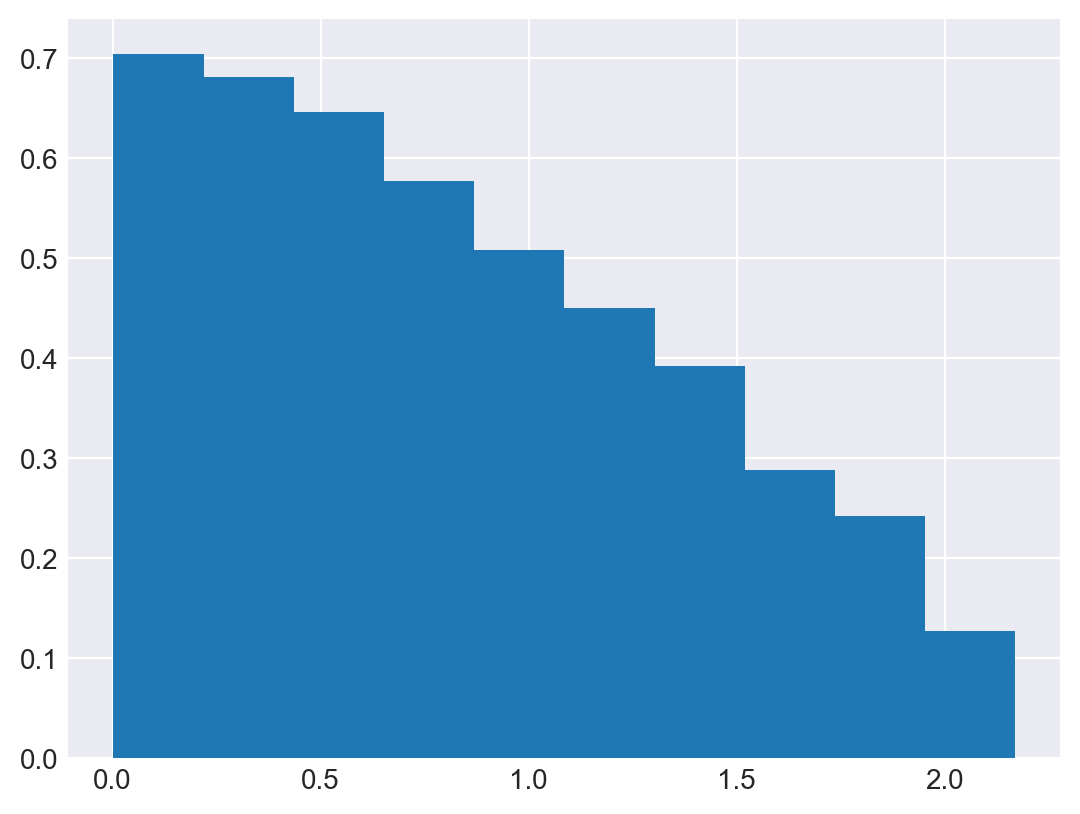

In [77]:
net2 = tk.TensorNetwork()
B = np.vstack((L, A, R)).T
# Create nodes at each vertex and connect the edges as given in the adjacency matrix
for i in np.arange(R.size):
    neighbor = np.nonzero(B[i]!=0)
    dim = B[i][neighbor] * D
    half_edges = ['(%i, %i)'%(i, j-1) for j in neighbor[0]]
    result = tk.randn(shape=np.zeros(dim).shape, axes_names=half_edges, network=net2)
    for j in np.arange(i):
        if np.any(np.array(half_edges) == '(%i, %i)'%(i, j)):
            net2['node_%i'%(i)]['(%i, %i)'%(i, j)] ^ net2['node_%i'%(j)]['(%i, %i)'%(j, i)]

# Contract the edges. Note there must be an edge between node_i and node_i+1. Otherwise, the following contraction would not work. 
for i in np.arange(R.size-2, -1, -1):
    result @= net2['node_%i'%(i)]

# Find all of the dangling edges to the left 
neighbor = np.nonzero(L)
half_edges = ['(%i, -1)'%(i) for i in neighbor[0]]
# Find all of the dangling edges to the right
neighbor = np.nonzero(R)
half_edges = half_edges + ['(%i, %i)'%(i, R.size) for i in neighbor[0]]
# Permute the axes of the tensor network to make sure that the axes 
result = tk.permute(result, half_edges)
svd2 = np.linalg.svd(result.tensor.reshape(D ** np.sum(L), D ** np.sum(R)), compute_uv=False)
normalized_svd2 = svd2 / D**(np.sum(B)/4)
plt.hist(normalized_svd2, density=True)

Print the moments for the normalied emperical eigenvalue distribution. 

In [80]:
for i in np.arange(1, 10):
    print(np.sum(normalized_svd2**(2*i))/normalized_svd2.size)

1.003203125
2.2258229064941406
6.407406616210937
21.03578369140625
74.7729296875
280.31337890625
1091.6778125
4374.8840625
17926.08625
